In [21]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import soundfile as sf
from IPython.display import Audio

In [2]:
# Local imports from your project structure
from model.gru_audio_model import RNN, GRUAudioConfig
from audioDataLoader.mulaw import mu_law_encode, mu_law_decode

In [6]:

run_directory = "./output/20250805_162729" #'Path to the directory of the saved run.'
top_n = 5 #'Sample from the top N most likely outputs.'
temperature =1.0 #'Controls the randomness of predictions.'
length_seconds =2.0 #'Length of the audio to generate in seconds.'

#parser.add_argument('--output_wav_path', type=str, default='generated_audio.wav', help='Path to save the output WAV file.')
#parser.add_argument('--output_plot_path', type=str, default='generated_waveform.png', help='Path to save the output plot.')


In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
config_path = os.path.join(run_directory, "config.pt")
checkpoint_path = os.path.join(run_directory, "checkpoints", "last_checkpoint.pt")

assert os.path.exists(run_directory), f"Run directory not found: {run_directory}"
assert os.path.exists(config_path), f"Config file not found: {config_path}"
assert os.path.exists(checkpoint_path), f"Checkpoint file not found: {checkpoint_path}"

saved_configs = torch.load(config_path, weights_only=False)
model_config = saved_configs["model_config"]

model = RNN(model_config).to(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model successfully loaded from checkpoint.")


Model successfully loaded from checkpoint.


In [3]:
# for generating parameters

def generate_condition_tensor(sr: int, duration: float, *param_specs) -> torch.FloatTensor:
    """
    Generate a [T, p] conditioning parameter tensor.

    Args:
        sr: Sample rate (samples per second)
        duration: Duration in seconds
        *param_specs: One list per parameter:
            [wave_type: str, phase: float (optional), cycles: float, scale: float (optional)]

    Returns:
        Tensor of shape [T, p] with values in [0,1]
    """
    T = int(sr * duration)
    t = np.linspace(0, duration, T, endpoint=False)  # time axis in seconds
    out = []

    for spec in param_specs:
        wave_type = spec[0]
        phase = spec[1] if len(spec) > 1 else 0.0
        cycles = spec[2] if len(spec) > 2 else 1.0
        scale = spec[3] if len(spec) > 3 else 1.0

        freq = cycles / duration
        radians = 2 * np.pi * freq * t + phase

        if wave_type == "sin":
            wave = np.sin(radians)
        elif wave_type == "sawtooth":
            wave = 2 * (radians / (2 * np.pi) % 1) - 1  # ramp from -1 to 1
        elif wave_type == "triangle":
            wave = 2 * np.abs(2 * (radians / (2 * np.pi) % 1) - 1) - 1
        elif wave_type == "square":
            wave = np.sign(np.sin(radians))
        else:
            raise ValueError(f"Unknown wave type: {wave_type}")

        wave = (wave * 0.5 + 0.5) * scale  # Normalize to [0,1] and apply scale
        out.append(wave)

    result = np.stack(out, axis=-1)  # shape [T, p]
    return torch.tensor(result, dtype=torch.float32)

def plot_condition_tensor(cond_tensor: torch.FloatTensor, sr: int):
    """
    Plot conditioning tensor of shape [T, p] with time in seconds on the x-axis.
    """
    T, p = cond_tensor.shape
    time = torch.arange(T) / sr

    plt.figure(figsize=(12, 4))
    for i in range(p):
        plt.plot(time, cond_tensor[:, i], label=f'Param {i+1}')
    
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized value")
    plt.title("Conditioning Parameters")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

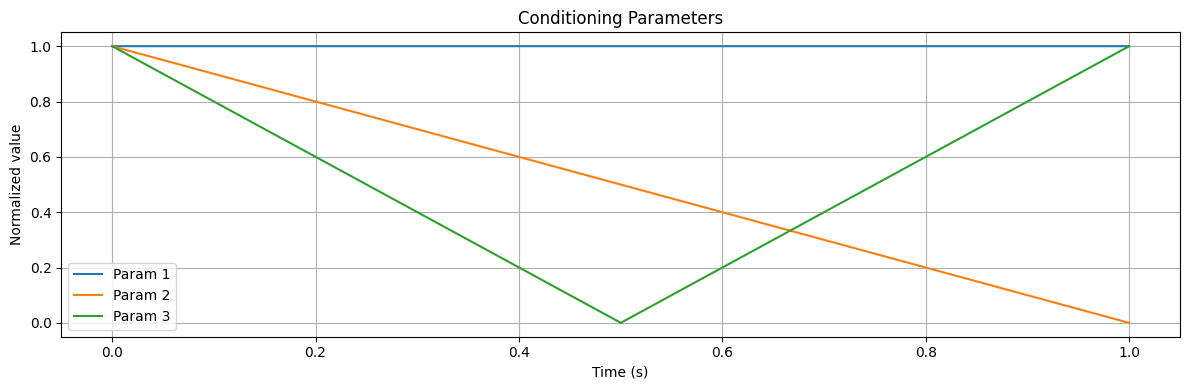

torch.Size([16000, 3])

In [4]:
#cond_tensor = generate_condition_tensor(16000, 1, ["square", 0.1, .05, .5], ["square", 0.1, .05, .5], ["square", 0.1, .05, .5])
cond_tensor = generate_condition_tensor(16000, 1, ["square", 0.1, .05, 1], ["triangle", 0, .5, 1], ["triangle", 0, 1, 1])
#cond_tensor = generate_condition_tensor(16000, 1, ["square", 0.1, .05, .333])
plot_condition_tensor(cond_tensor, 16000)
cond_tensor.shape

In [12]:
def run_inference(model, cond_seq, warmup_sequence, top_n=3, temperature=1.0):
    """
    Generates audio sequence based on a conditioning sequence.

    Args:
        model: The trained RNN model.
        cond_seq (torch.Tensor): The sequence of conditioning parameters. Shape: (seq_len, num_cond_params).
        warmup_sequence (torch.Tensor): A raw audio sequence to warm up the model's hidden state. Shape: (warmup_len,).
        top_n (int): The number of top predictions to sample from.
        temperature (float): Controls the randomness of predictions. Higher is more random.

    Returns:
        np.array: The generated audio waveform.
    """
    device = next(model.parameters()).device
    print("Starting inference...")

    # --- 1. Warm-up Phase --- 
    print("Warming up model hidden state...")
    warmup_encoded = mu_law_encode(warmup_sequence, quantization_channels=256)
    warmup_input_audio = (warmup_encoded.float() / 255.0).to(device)

    first_cond_vec = cond_seq[0].unsqueeze(0).repeat(len(warmup_input_audio), 1).to(device)
    warmup_full_input = torch.cat([warmup_input_audio.unsqueeze(-1), first_cond_vec], dim=-1)

    hidden = model.init_hidden(batch_size=1)
    for i in range(len(warmup_full_input)):
        _, hidden = model(warmup_full_input[i].unsqueeze(0), hidden, batch_size=1)

    next_input_audio = warmup_input_audio[-1].unsqueeze(0)

    # --- 2. Generation Phase --- 
    print(f"Generating {len(cond_seq)} audio samples...")
    generated_samples = []
    with torch.no_grad():
        for i in range(len(cond_seq)):
            current_cond_vec = cond_seq[i].unsqueeze(0).to(device)
            next_input_full = torch.cat([next_input_audio.unsqueeze(-1), current_cond_vec], dim=-1)

            logits, hidden = model(next_input_full, hidden, batch_size=1)

            logits = logits.div(temperature).squeeze()
            top_n_logits, top_n_indices = torch.topk(logits, top_n)
            top_n_probs = F.softmax(top_n_logits, dim=-1)
            sampled_relative_idx = torch.multinomial(top_n_probs, 1).squeeze()
            sampled_mu_law_index = top_n_indices[sampled_relative_idx]

            new_audio_sample = mu_law_decode(sampled_mu_law_index, quantization_channels=256)
            generated_samples.append(new_audio_sample.item())

            next_input_audio = (mu_law_encode(new_audio_sample.unsqueeze(0), 256).float() / 255.0).to(device)

    print("Inference complete.")
    return np.array(generated_samples)

In [14]:
sample_rate = 16000
generation_length = int(length_seconds * sample_rate)

num_cond_params = model_config.cond_size
cond_seq = torch.zeros(generation_length, num_cond_params)
cond_seq[:, 0] = 0.0
cond_seq[:, 1] = 0.8
cond_seq[:, 2] = torch.linspace(0, 1, generation_length)


In [17]:
warmup_len = 512
t = torch.linspace(0., 1., warmup_len)
warmup_sequence = torch.sin(2 * np.pi * 220.0 * t)

generated_audio = run_inference(
    model=model,
    cond_seq=cond_seq,
    warmup_sequence=warmup_sequence,
    top_n=top_n,
    temperature=temperature
)

Starting inference...
Warming up model hidden state...
Generating 32000 audio samples...
Inference complete.


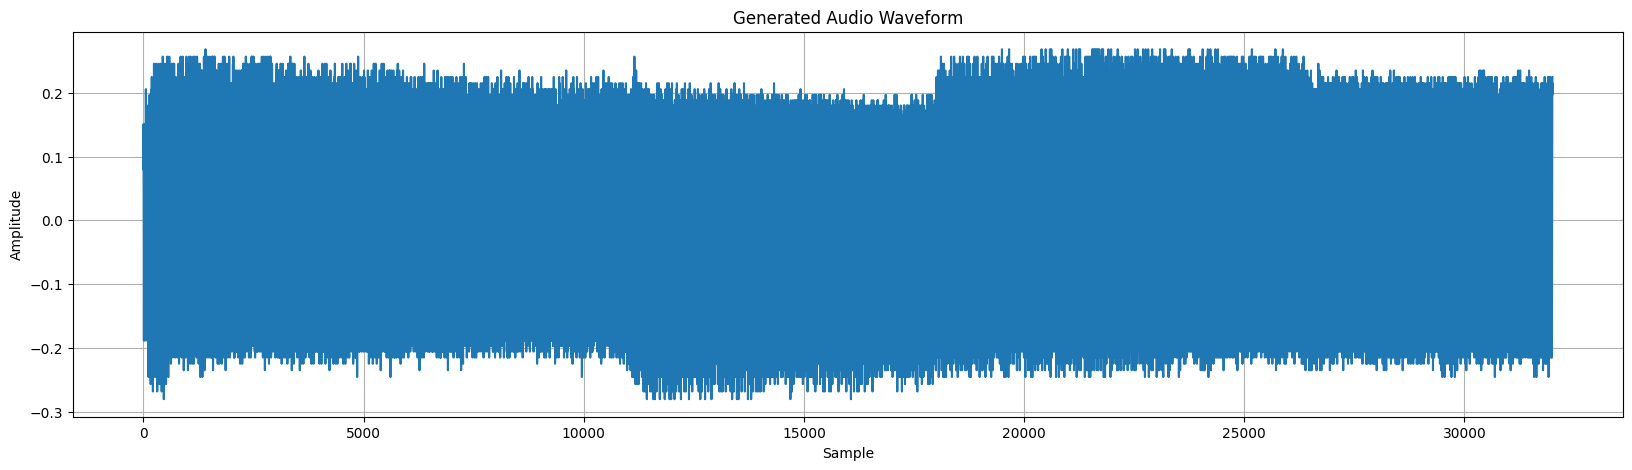

In [19]:
#print(f"Saving waveform plot to {args.output_plot_path}")
plt.figure(figsize=(20, 5))
plt.plot(generated_audio)
plt.title("Generated Audio Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
#plt.savefig(args.output_plot_path)
#plt.close()

plt.show()

In [22]:
Audio(generated_audio, rate=16000)